In [98]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import IPython.display as ipd
from scipy.io import wavfile as wav
from tqdm.notebook import tqdm
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import random
import copy

In [99]:
#Loading, training and testing of input files
#And computing STFT on all the files

s, sr = librosa.load('train_clean_male.wav', sr=None)
S = librosa.stft(s, n_fft=1024, hop_length=512)

sn, sr = librosa.load('train_dirty_male.wav', sr=None)
X = librosa.stft(sn, n_fft=1024, hop_length=512)

x_test, sr = librosa.load('test_x_01.wav', sr=None)
X_test = librosa.stft(x_test, n_fft=1024, hop_length=512)

x_test2, sr = librosa.load('test_x_02.wav', sr=None)
X_test2 = librosa.stft(x_test2, n_fft=1024, hop_length=512)

In [100]:
#Calculating the magnitude of all the input files

mag_S = np.abs(S)
mag_X = np.abs(X)
mag_X_test = np.abs(X_test)
mag_X_test2 = np.abs(X_test2)

In [101]:
input = tf.placeholder(tf.float32, [None, 513])
labels = tf.placeholder(tf.float32, [None, 513])

In [102]:
def getModel(x):
  # Input Layer
  input_layer = tf.reshape(x, [-1, 20, 513, 1])

  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=16,
      kernel_size=[4,4],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2], strides=[2,2])

  # Convolutional Layer #2 and Pooling Layer #2
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=32,
      kernel_size=[2,2],
      padding="same",
      activation=tf.nn.relu)
  
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2], strides=[2,2])

  # Dense Layer
  pool2_flat = tf.layers.flatten(pool2)
  
  logits = tf.layers.dense(inputs=pool2_flat, units=513, activation=tf.nn.relu)
  
  return logits

In [103]:
def transform_data(x , size , window_size):
  temp = x[0 : 0 + window_size,:]
  for i in range(1 , size - window_size + 1):
      temp_mini = x[i : i + window_size,:]
      temp = np.vstack((temp , temp_mini))
      
  return temp

In [104]:
#Transforming the data in such a way that it takes 20 current and previous input frames
transformed_x = transform_data(mag_X.T , np.shape(mag_X.T)[0] , window_size)

In [105]:
#Keeping a copy of transformed x because we will require it later on to calculate the SNR
transformed_x1 = copy.deepcopy(transformed_x)

In [106]:
#Transforming the input data into 2D format
transformed_x = np.reshape(transformed_x , (2440 , 20 , 513))

In [107]:
#Dropping first 19 frames from y(clean wave) signal
transformed_y = (mag_S.T)[window_size - 1 : , :]

In [108]:
learning_rate = 0.0002
num_epochs = 500
batch_size = 64
window_size = 20

In [109]:
output = getModel(input)
#Defining the loss function along with its optimizer
loss = tf.reduce_mean(tf.square(output - labels))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

count = 0
flag = True

for count in tqdm(range(num_epochs)):
    size = 0
    #Mini batching with the given batch size
    for i in tqdm(range(0 , 2440, batch_size)):
        size += batch_size
        if size <= 2440:
            batch_x = transformed_x[i : size, :]
            batch_y = transformed_y[i : size, :]
        else:
            batch_x = transformed_x[i : 2440, :]
            batch_y = transformed_y[i : 2440, :]
        
        
        batch_x = batch_x.reshape((np.shape(batch_x)[0] * np.shape(batch_x)[1] , np.shape(batch_x)[2]))
        feed_dict = {input: batch_x, labels: batch_y}
        train_step.run(feed_dict=feed_dict)

    if count%1 == 0:
        loss_calc = loss.eval(feed_dict=feed_dict)
        print("Epoch %d, loss %g"%(count+1, loss_calc))
    

C:\Users\hp\anaconda3\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\convolutional.py:414: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  warnings.warn('`tf.layers.conv2d` is deprecated and '
C:\Users\hp\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
C:\Users\hp\anaconda3\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\pooling.py:310: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  warnings.warn('`tf.layers.max_pooling2d` is deprecated and '
C:\Users\hp\anaconda3\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:329: UserWarning: `tf.layers.flatten` is dep


Epoch 1, loss 0.00570699



Epoch 2, loss 0.00393715



Epoch 3, loss 0.00304105



Epoch 4, loss 0.0023397



Epoch 5, loss 0.00194794



Epoch 6, loss 0.00166345



Epoch 7, loss 0.00165449



Epoch 8, loss 0.00140925



Epoch 9, loss 0.0014499



Epoch 10, loss 0.00144837



Epoch 11, loss 0.00160304



Epoch 12, loss 0.00140327



Epoch 13, loss 0.00151125



Epoch 14, loss 0.00150848



Epoch 15, loss 0.00239055



Epoch 16, loss 0.00152135



Epoch 17, loss 0.00129829



Epoch 18, loss 0.00123768



Epoch 19, loss 0.00116531



Epoch 20, loss 0.00109795



Epoch 21, loss 0.0011197



Epoch 22, loss 0.0011372



Epoch 23, loss 0.00108219



Epoch 24, loss 0.0010772



Epoch 25, loss 0.00108942



Epoch 26, loss 0.00111034



Epoch 27, loss 0.00104642



Epoch 28, loss 0.00100248



Epoch 29, loss 0.00116681



Epoch 30, loss 0.000970874



Epoch 31, loss 0.00108225



Epoch 32, loss 0.00109742



Epoch 33, loss 0.00106445



Epoch 34, loss 0.000990426



Epoch 35, loss 0.00107339



Epoch 36, loss 0.00101549



Epoch 37, loss 0.000999582



Epoch 38, loss 0.000988835



Epoch 39, loss 0.000970593



Epoch 40, loss 0.000888068



Epoch 41, loss 0.000919959



Epoch 42, loss 0.000955452



Epoch 43, loss 0.000915811



Epoch 44, loss 0.000892558



Epoch 45, loss 0.000872307



Epoch 46, loss 0.000865013



Epoch 47, loss 0.000811429



Epoch 48, loss 0.000804793



Epoch 49, loss 0.000884564



Epoch 50, loss 0.000852005



Epoch 51, loss 0.000850051



Epoch 52, loss 0.000814658



Epoch 53, loss 0.00082867



Epoch 54, loss 0.000828596



Epoch 55, loss 0.000838029



Epoch 56, loss 0.000803147



Epoch 57, loss 0.000790161



Epoch 58, loss 0.000815088



Epoch 59, loss 0.000889686



Epoch 60, loss 0.000841621



Epoch 61, loss 0.00092901



Epoch 62, loss 0.00090898



Epoch 63, loss 0.000980463



Epoch 64, loss 0.000850727



Epoch 65, loss 0.00081773



Epoch 66, loss 0.000912278



Epoch 67, loss 0.000971315



Epoch 68, loss 0.000863076



Epoch 69, loss 0.000805653



Epoch 70, loss 0.000758212



Epoch 71, loss 0.000785482



Epoch 72, loss 0.000752209



Epoch 73, loss 0.000698981



Epoch 74, loss 0.000721471



Epoch 75, loss 0.000790601



Epoch 76, loss 0.000733076



Epoch 77, loss 0.000725667



Epoch 78, loss 0.000719486



Epoch 79, loss 0.000684592



Epoch 80, loss 0.000672424



Epoch 81, loss 0.000678916



Epoch 82, loss 0.000745448



Epoch 83, loss 0.000662316



Epoch 84, loss 0.000622857



Epoch 85, loss 0.000639441



Epoch 86, loss 0.000632909



Epoch 87, loss 0.000627504



Epoch 88, loss 0.000650443



Epoch 89, loss 0.000669326



Epoch 90, loss 0.000643992



Epoch 91, loss 0.000611621



Epoch 92, loss 0.000609487



Epoch 93, loss 0.00059692



Epoch 94, loss 0.000582566



Epoch 95, loss 0.000597096



Epoch 96, loss 0.00067154



Epoch 97, loss 0.000617426



Epoch 98, loss 0.000573373



Epoch 99, loss 0.000574953



Epoch 100, loss 0.000584322



Epoch 101, loss 0.000609351



Epoch 102, loss 0.000572654



Epoch 103, loss 0.000589162



Epoch 104, loss 0.000613964



Epoch 105, loss 0.0006312



Epoch 106, loss 0.000626259



Epoch 107, loss 0.000627048



Epoch 108, loss 0.000629685



Epoch 109, loss 0.000588924



Epoch 110, loss 0.000568275



Epoch 111, loss 0.000583567



Epoch 112, loss 0.000608967



Epoch 113, loss 0.000607394



Epoch 114, loss 0.00062736



Epoch 115, loss 0.000580942



Epoch 116, loss 0.000595671



Epoch 117, loss 0.000618364



Epoch 118, loss 0.000696323



Epoch 119, loss 0.000678925



Epoch 120, loss 0.000665713



Epoch 121, loss 0.000712207



Epoch 122, loss 0.000672046



Epoch 123, loss 0.000631484



Epoch 124, loss 0.000590725



Epoch 125, loss 0.000629252



Epoch 126, loss 0.000631049



Epoch 127, loss 0.000599098



Epoch 128, loss 0.000592456



Epoch 129, loss 0.000584767



Epoch 130, loss 0.0005785



Epoch 131, loss 0.000573186



Epoch 132, loss 0.000578451



Epoch 133, loss 0.000564431



Epoch 134, loss 0.000549594



Epoch 135, loss 0.000550206



Epoch 136, loss 0.000585358



Epoch 137, loss 0.000555188



Epoch 138, loss 0.00053059



Epoch 139, loss 0.000536494



Epoch 140, loss 0.000530206



Epoch 141, loss 0.000519093



Epoch 142, loss 0.000533313



Epoch 143, loss 0.000528004



Epoch 144, loss 0.000517812



Epoch 145, loss 0.00053851



Epoch 146, loss 0.000519958



Epoch 147, loss 0.000514858



Epoch 148, loss 0.000523528



Epoch 149, loss 0.000531949



Epoch 150, loss 0.000513141



Epoch 151, loss 0.000513364



Epoch 152, loss 0.000519741



Epoch 153, loss 0.000508194



Epoch 154, loss 0.000506279



Epoch 155, loss 0.000522755



Epoch 156, loss 0.00052842



Epoch 157, loss 0.000511679



Epoch 158, loss 0.000505886



Epoch 159, loss 0.000500202



Epoch 160, loss 0.000525111



Epoch 161, loss 0.000517378



Epoch 162, loss 0.000536828



Epoch 163, loss 0.000535154



Epoch 164, loss 0.000549132



Epoch 165, loss 0.000544066



Epoch 166, loss 0.000529284



Epoch 167, loss 0.000538273



Epoch 168, loss 0.000625523



Epoch 169, loss 0.000590388



Epoch 170, loss 0.000591896



Epoch 171, loss 0.000606465



Epoch 172, loss 0.000627625



Epoch 173, loss 0.000601945



Epoch 174, loss 0.000623248



Epoch 175, loss 0.000637965



Epoch 176, loss 0.000617581



Epoch 177, loss 0.000618399



Epoch 178, loss 0.000614083



Epoch 179, loss 0.000590301



Epoch 180, loss 0.000569849



Epoch 181, loss 0.00057474



Epoch 182, loss 0.000577466



Epoch 183, loss 0.000541784



Epoch 184, loss 0.000543876



Epoch 185, loss 0.000516703



Epoch 186, loss 0.000517087



Epoch 187, loss 0.00051284



Epoch 188, loss 0.000502969



Epoch 189, loss 0.000500349



Epoch 190, loss 0.000523534



Epoch 191, loss 0.000492856



Epoch 192, loss 0.000495424



Epoch 193, loss 0.000489668



Epoch 194, loss 0.000487828



Epoch 195, loss 0.000498896



Epoch 196, loss 0.000495402



Epoch 197, loss 0.000497173



Epoch 198, loss 0.000494812



Epoch 199, loss 0.00050292



Epoch 200, loss 0.000503165



Epoch 201, loss 0.000500546



Epoch 202, loss 0.000505934



Epoch 203, loss 0.000502558



Epoch 204, loss 0.000499404



Epoch 205, loss 0.000496651



Epoch 206, loss 0.000493104



Epoch 207, loss 0.00048903



Epoch 208, loss 0.000482568



Epoch 209, loss 0.000483244



Epoch 210, loss 0.000477895



Epoch 211, loss 0.000482507



Epoch 212, loss 0.000479712



Epoch 213, loss 0.000488537



Epoch 214, loss 0.000478784



Epoch 215, loss 0.000484515



Epoch 216, loss 0.000483106



Epoch 217, loss 0.000485262



Epoch 218, loss 0.000489481



Epoch 219, loss 0.000483537



Epoch 220, loss 0.000481421



Epoch 221, loss 0.000486395



Epoch 222, loss 0.000510063



Epoch 223, loss 0.00052154



Epoch 224, loss 0.000534356



Epoch 225, loss 0.000535406



Epoch 226, loss 0.000538961



Epoch 227, loss 0.000545384



Epoch 228, loss 0.000541609



Epoch 229, loss 0.000547117



Epoch 230, loss 0.000507653



Epoch 231, loss 0.000492137



Epoch 232, loss 0.000483659



Epoch 233, loss 0.000484319



Epoch 234, loss 0.000486708



Epoch 235, loss 0.000477331



Epoch 236, loss 0.000478029



Epoch 237, loss 0.000494112



Epoch 238, loss 0.000520902



Epoch 239, loss 0.000473082



Epoch 240, loss 0.000486429



Epoch 241, loss 0.000492159



Epoch 242, loss 0.000520407



Epoch 243, loss 0.000499524



Epoch 244, loss 0.000495168



Epoch 245, loss 0.000496462



Epoch 246, loss 0.000516806



Epoch 247, loss 0.00054875



Epoch 248, loss 0.000557973



Epoch 249, loss 0.000555671



Epoch 250, loss 0.000523077



Epoch 251, loss 0.000492493



Epoch 252, loss 0.000490738



Epoch 253, loss 0.000482817



Epoch 254, loss 0.000460045



Epoch 255, loss 0.000448399



Epoch 256, loss 0.000436539



Epoch 257, loss 0.000440253



Epoch 258, loss 0.000432641



Epoch 259, loss 0.000427151



Epoch 260, loss 0.000433313



Epoch 261, loss 0.000424133



Epoch 262, loss 0.000424987



Epoch 263, loss 0.000432658



Epoch 264, loss 0.000439127



Epoch 265, loss 0.000435518



Epoch 266, loss 0.000440417



Epoch 267, loss 0.000435906



Epoch 268, loss 0.000430957



Epoch 269, loss 0.000446425



Epoch 270, loss 0.000456885



Epoch 271, loss 0.000468756



Epoch 272, loss 0.000469617



Epoch 273, loss 0.000488982



Epoch 274, loss 0.000479373



Epoch 275, loss 0.000476453



Epoch 276, loss 0.00046512



Epoch 277, loss 0.000443648



Epoch 278, loss 0.000438342



Epoch 279, loss 0.000428576



Epoch 280, loss 0.000424659



Epoch 281, loss 0.00041815



Epoch 282, loss 0.000414525



Epoch 283, loss 0.000422358



Epoch 284, loss 0.000419942



Epoch 285, loss 0.00042202



Epoch 286, loss 0.000420241



Epoch 287, loss 0.00041895



Epoch 288, loss 0.000432217



Epoch 289, loss 0.000446262



Epoch 290, loss 0.000457476



Epoch 291, loss 0.000462268



Epoch 292, loss 0.000481904



Epoch 293, loss 0.000493005



Epoch 294, loss 0.000492407



Epoch 295, loss 0.00050764



Epoch 296, loss 0.000501898



Epoch 297, loss 0.000489902



Epoch 298, loss 0.000475651



Epoch 299, loss 0.000466219



Epoch 300, loss 0.000448768



Epoch 301, loss 0.000430402



Epoch 302, loss 0.000422603



Epoch 303, loss 0.000415692



Epoch 304, loss 0.000417983



Epoch 305, loss 0.000410192



Epoch 306, loss 0.000420109



Epoch 307, loss 0.000418108



Epoch 308, loss 0.00041916



Epoch 309, loss 0.000435495



Epoch 310, loss 0.000430074



Epoch 311, loss 0.000424543



Epoch 312, loss 0.000425829



Epoch 313, loss 0.000438718



Epoch 314, loss 0.000464695



Epoch 315, loss 0.000464682



Epoch 316, loss 0.000459674



Epoch 317, loss 0.000464305



Epoch 318, loss 0.000455053



Epoch 319, loss 0.000458909



Epoch 320, loss 0.000450717



Epoch 321, loss 0.000443771



Epoch 322, loss 0.000440732



Epoch 323, loss 0.000430326



Epoch 324, loss 0.000427712



Epoch 325, loss 0.000426129



Epoch 326, loss 0.000415314



Epoch 327, loss 0.000410103



Epoch 328, loss 0.000408084



Epoch 329, loss 0.000411717



Epoch 330, loss 0.00041465



Epoch 331, loss 0.000412544



Epoch 332, loss 0.000408831



Epoch 333, loss 0.000413634



Epoch 334, loss 0.000414116



Epoch 335, loss 0.000412871



Epoch 336, loss 0.000417973



Epoch 337, loss 0.000421422



Epoch 338, loss 0.0004152



Epoch 339, loss 0.000420633



Epoch 340, loss 0.000426247



Epoch 341, loss 0.000431201



Epoch 342, loss 0.000444165



Epoch 343, loss 0.000471596



Epoch 344, loss 0.000458071



Epoch 345, loss 0.000449272



Epoch 346, loss 0.000424093



Epoch 347, loss 0.000402521



Epoch 348, loss 0.000383928



Epoch 349, loss 0.000383125



Epoch 350, loss 0.000371114



Epoch 351, loss 0.000375311



Epoch 352, loss 0.000373089



Epoch 353, loss 0.000363278



Epoch 354, loss 0.000363496



Epoch 355, loss 0.000360032



Epoch 356, loss 0.00036367



Epoch 357, loss 0.000367441



Epoch 358, loss 0.000370455



Epoch 359, loss 0.000372328



Epoch 360, loss 0.000373037



Epoch 361, loss 0.000380006



Epoch 362, loss 0.000387059



Epoch 363, loss 0.000388516



Epoch 364, loss 0.000389122



Epoch 365, loss 0.000393379



Epoch 366, loss 0.000405247



Epoch 367, loss 0.000417333



Epoch 368, loss 0.000428232



Epoch 369, loss 0.000427029



Epoch 370, loss 0.000418882



Epoch 371, loss 0.000401907



Epoch 372, loss 0.000386572



Epoch 373, loss 0.000376952



Epoch 374, loss 0.000370831



Epoch 375, loss 0.000364658



Epoch 376, loss 0.00036007



Epoch 377, loss 0.000359642



Epoch 378, loss 0.000364617



Epoch 379, loss 0.000363309



Epoch 380, loss 0.000369526



Epoch 381, loss 0.000381515



Epoch 382, loss 0.000375469



Epoch 383, loss 0.000368783



Epoch 384, loss 0.00037001



Epoch 385, loss 0.000387591



Epoch 386, loss 0.00039497



Epoch 387, loss 0.00040548



Epoch 388, loss 0.000409891



Epoch 389, loss 0.000409785



Epoch 390, loss 0.000411756



Epoch 391, loss 0.000412322



Epoch 392, loss 0.000424454



Epoch 393, loss 0.000405242



Epoch 394, loss 0.000387807



Epoch 395, loss 0.000379283



Epoch 396, loss 0.000372988



Epoch 397, loss 0.000370707



Epoch 398, loss 0.000362608



Epoch 399, loss 0.000359534



Epoch 400, loss 0.000355845



Epoch 401, loss 0.000354885



Epoch 402, loss 0.000353772



Epoch 403, loss 0.000362611



Epoch 404, loss 0.000359361



Epoch 405, loss 0.000362733



Epoch 406, loss 0.000361081



Epoch 407, loss 0.000362748



Epoch 408, loss 0.00037148



Epoch 409, loss 0.000389823



Epoch 410, loss 0.000393876



Epoch 411, loss 0.000413071



Epoch 412, loss 0.000413109



Epoch 413, loss 0.000416714



Epoch 414, loss 0.000408232



Epoch 415, loss 0.00040098



Epoch 416, loss 0.000398208



Epoch 417, loss 0.000402841



Epoch 418, loss 0.000396623



Epoch 419, loss 0.000388551



Epoch 420, loss 0.000376174



Epoch 421, loss 0.000371119



Epoch 422, loss 0.00037094



Epoch 423, loss 0.000362316



Epoch 424, loss 0.000358515



Epoch 425, loss 0.00035867



Epoch 426, loss 0.000359543



Epoch 427, loss 0.000356179



Epoch 428, loss 0.000358514



Epoch 429, loss 0.000356623



Epoch 430, loss 0.000362742



Epoch 431, loss 0.000362655



Epoch 432, loss 0.000363189



Epoch 433, loss 0.000372118



Epoch 434, loss 0.000365745



Epoch 435, loss 0.0003416



Epoch 436, loss 0.000333585



Epoch 437, loss 0.000328951



Epoch 438, loss 0.000328891



Epoch 439, loss 0.000338742



Epoch 440, loss 0.000341534



Epoch 441, loss 0.00035189



Epoch 442, loss 0.000364139



Epoch 443, loss 0.00037374



Epoch 444, loss 0.00037324



Epoch 445, loss 0.000380506



Epoch 446, loss 0.000379415



Epoch 447, loss 0.000356815



Epoch 448, loss 0.000351847



Epoch 449, loss 0.000354954



Epoch 450, loss 0.000340781



Epoch 451, loss 0.000330709



Epoch 452, loss 0.000326996



Epoch 453, loss 0.00032331



Epoch 454, loss 0.000324005



Epoch 455, loss 0.000321033



Epoch 456, loss 0.000322288



Epoch 457, loss 0.000327661



Epoch 458, loss 0.000330355



Epoch 459, loss 0.000333948



Epoch 460, loss 0.000325258



Epoch 461, loss 0.000324263



Epoch 462, loss 0.000339597



Epoch 463, loss 0.000331688



Epoch 464, loss 0.000334378



Epoch 465, loss 0.000337173



Epoch 466, loss 0.000342483



Epoch 467, loss 0.000348365



Epoch 468, loss 0.000352428



Epoch 469, loss 0.000354105



Epoch 470, loss 0.000356265



Epoch 471, loss 0.000353712



Epoch 472, loss 0.000353027



Epoch 473, loss 0.000354391



Epoch 474, loss 0.000349237



Epoch 475, loss 0.000342482



Epoch 476, loss 0.000333574



Epoch 477, loss 0.000330266



Epoch 478, loss 0.000325125



Epoch 479, loss 0.000322576



Epoch 480, loss 0.00032004



Epoch 481, loss 0.000320314



Epoch 482, loss 0.000322214



Epoch 483, loss 0.000321845



Epoch 484, loss 0.000320205



Epoch 485, loss 0.000329385



Epoch 486, loss 0.000334511



Epoch 487, loss 0.000329286



Epoch 488, loss 0.000322154



Epoch 489, loss 0.00032345



Epoch 490, loss 0.00032665



Epoch 491, loss 0.000330892



Epoch 492, loss 0.000346459



Epoch 493, loss 0.000357627



Epoch 494, loss 0.00035987



Epoch 495, loss 0.000353044



Epoch 496, loss 0.000351163



Epoch 497, loss 0.000345829



Epoch 498, loss 0.000338241



Epoch 499, loss 0.000332301



Epoch 500, loss 0.000328994



In [110]:
#Calculating the output from the given input, trained model and layer number

def feedforward(input_data, dnn_output):
    output = dnn_output.eval(feed_dict = {input : input_data})
    
    return output

#Recovering the complex values of the file from the output of the model
def recover_sound(X , mag_X , mag_output):
  temp = X / mag_X
  s_hat = temp * mag_output
  
  return s_hat

#Recovering the lost frames
def recover_data(x , size , value):
  temp = np.full(size , value)
  output = np.vstack((temp , x))
  
  return output

In [111]:
#Transforming the data in such a way that it be given to the model for testing

transformed_x_test = transform_data(mag_X_test.T , np.shape(mag_X_test.T)[0] , window_size)
transformed_x_test2 = transform_data(mag_X_test2.T , np.shape(mag_X_test2.T)[0] , window_size)

In [112]:
#Computing the output from the model for both the test files
s_hat_test1 = feedforward(transformed_x_test , output)
s_hat_test2 = feedforward(transformed_x_test2 , output)

#Recovering the first 19 frames that were lost
recovered_x_test1 = recover_data(s_hat_test1 , (window_size - 1 , np.shape(s_hat_test1)[1]) , 1e-15)
recovered_x_test2 = recover_data(s_hat_test2 , (window_size - 1 , np.shape(s_hat_test2)[1]) , 1e-15)

#Recovering the complex values of both the test files
s_hat1 = recover_sound(X_test , mag_X_test , recovered_x_test1.T)
s_hat2 = recover_sound(X_test2 , mag_X_test2 , recovered_x_test2.T)

In [113]:
#Reconstructing the test files after removing noise
recon_sound = librosa.istft(s_hat1 , hop_length=512 , win_length=1024)
sf.write('test_s_01_recons_q1.wav',  recon_sound, sr)

# data, samplerate = sf.read('existing_file.wav')
recon_sound2 = librosa.istft(s_hat2 , hop_length=512 , win_length=1024)
sf.write('test_s_02_recons_q1.wav',recon_sound2, sr)

In [114]:
#For testing purpose, feeding the model with train_dirty_male file
#From the output generated, reconstructing the audio file

s_hat_test3 = feedforward(transformed_x1 , output)
recovered_x1 = recover_data(s_hat_test3 , (window_size - 1 , np.shape(s_hat_test3)[1]) , 1e-15)
s_hat3 = recover_sound(X, mag_X , recovered_x1.T)

recon_sound3 = librosa.istft(s_hat3 , hop_length=512 , win_length=1024)
size_recon_sound3 = np.shape(recon_sound3)[0]

In [117]:
#Once the audio file is gener#For testing purpose, feeding the model with train_dirty_male file
#From the output generated, reconstructing the audio file

s_hat_test3 = feedforward(transformed_x1 , output)
recovered_x1 = recover_data(s_hat_test3 , (window_size - 1 , np.shape(s_hat_test3)[1]) , 1e-15)
s_hat3 = recover_sound(X, mag_X , recovered_x1.T)

recon_sound3 = librosa.istft(s_hat3 , hop_length=512 , win_length=1024)
size_recon_sound3 = np.shape(recon_sound3)[0]ated, calculating the SNR value

s = s[: size_recon_sound3]
num = np.dot(s.T , s)
den = np.dot((s - recon_sound3).T,(s - recon_sound3))
SNR = 10 * np.log10(num/den)
print('Value of SNR : ' + str(SNR))

Value of SNR : 16.28388285636902


In [118]:
# 2D CNN denoised audio file 1 output

print("2D CNN output_test_x_02\n")
ipd.Audio('test_s_01_recons_q2.wav')

2D CNN output_test_x_02



In [119]:
# 2D CNN denoised audio file 2 output

print("2D CNN output_test_x_02\n")
ipd.Audio('test_s_02_recons_q2.wav')

2D CNN output_test_x_02



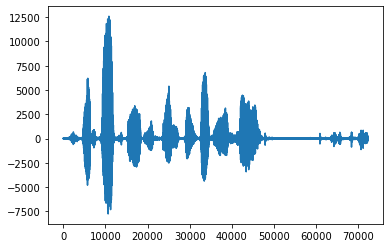

In [120]:
# 2D CNN denoised audio file 1

rate, data = wav.read('test_s_01_recons_q2.wav')
%matplotlib inline
plt.plot(data)
plt.show()

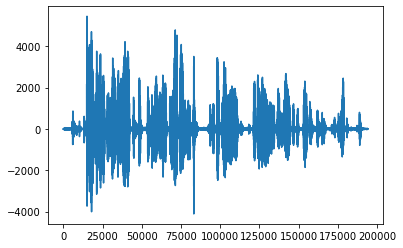

In [121]:
# 2D CNN denoised audio file 2

rate, data = wav.read('test_s_02_recons_q2.wav')
%matplotlib inline
plt.plot(data)
plt.show()